Импорты

In [201]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import matplotlib.pyplot as plt
import cv2
import numpy as np
import segmentation_models_pytorch as smp
from tqdm import tqdm
import sys

Датасет выбрал Person Segmentation: https://www.kaggle.com/datasets/nikhilroxtomar/person-segmentation/data

Датасет содержит бинарную классификацию для сегментации изображений людей.
Это полезно для построения систем безопасности и охраны, а также для распознавания пешеходов в беспилотных автомобилях.

In [ ]:
!mkdir lab7

Подпапка или файл lab7 уже существует.


In [ ]:
%cd lab7

In [ ]:
!dir

Параметры

In [188]:
sz = (256, 256)
batch_len = 4
workers = 0
epoch_num = 10
lr = 0.0001

Метрики качества возьмем:
* IoU - одна из самых популярных метрик в сегментации
* Recall - процент случаев торможения перед пешеходом, важно
* F1-score - полезен при дисбалансе классов

In [189]:
def calculate_iou(pred, target):
  # print('iou pred and target', pred.shape, target.shape)
  intersection = (pred & target).float().sum((1, 2))
  union = (pred | target).float().sum((1, 2))
  iou = (intersection + 1e-6) / (union + 1e-6)  # размерность - батч
  return iou.mean()  # вычисляем среднее по батчу

def calculate_recall(pred, target):
  # print('rc pred and target', pred.shape, target.shape)
  intersection = (pred & target).float().sum((1, 2))
  relevant = target.float().sum((1, 2))
  rc = (intersection + 1e-6) / (relevant + 1e-6)
  return rc.mean()

def calculate_f1(pred, target):
  # print('f1 pred and target', pred.shape, target.shape)
  intersection = (pred & target).float().sum((1, 2))
  denom = pred.float().sum((1, 2)) + target.float().sum((1, 2))
  f1 = (2 * intersection + 1e-6) / (denom + 1e-6)
  return f1.mean()

Настройка девайса

In [190]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

Используемое устройство: cuda


Подготовка датасета

In [ ]:
%cd lab7/archive/
!dir

In [191]:
better_train_trans = A.Compose([
        A.Resize(sz[0], sz[1]),
        A.RandomResizedCrop(size=(sz), scale=(0.2, 1.0), p=0.5),
        A.HorizontalFlip(0.5),
        A.VerticalFlip(0.1),
        A.RandomRotate90(p=0.5),
        A.RandomBrightnessContrast(p=0.3),
        A.RandomGamma(p=0.2),
        A.GaussianBlur(p=0.2),
        A.ElasticTransform(p=0.2),
        A.GridDistortion(p=0.1),
        A.OpticalDistortion(p=0.1),
        ])
better_val_trans = A.Compose([
        A.Resize(sz[0], sz[1])
        ])


train_trans = A.Compose([
        A.Resize(sz[0], sz[1]),
        A.RandomResizedCrop(size=(sz), scale=(0.2, 1.0), p=0.5),
        A.HorizontalFlip(0.5),
        A.VerticalFlip(0.1)
        ])
val_trans = A.Compose([
        A.Resize(sz[0], sz[1])
        ])

class myDataset(torch.utils.data.Dataset):
  def __init__(
      self,
    image_paths = None,
    masks_paths = None,
    mode = None,
    ttrans = None,
    vtrans = None
  ):
    self.image_paths = image_paths
    self.masks_paths = masks_paths
    self.mode = mode
    self.train_transforms = ttrans
    self.val_transforms = vtrans

  def __getitem__(self, i):
    imgpath = self.image_paths[i]
    img = cv2.imread(imgpath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    maskpath = self.masks_paths[i]
    mask = mask = cv2.imread(maskpath, cv2.IMREAD_UNCHANGED)

    if self.mode == "train":
        transformed = self.train_transforms(image=img, mask=mask)
    else:
        transformed = self.val_transforms(image=img, mask=mask)
    img = transformed['image']
    mask = transformed['mask']

    img = torch.from_numpy(img.astype(np.float32)).clone()
    img = img.permute(2, 0, 1)
    mask = mask.astype(np.float32)
    mask = torch.from_numpy(mask)
    mask = mask.unsqueeze(0)

    data = (img, mask)
    return data

  def __len__(self):
    return len(self.image_paths)


def read_file_list(file_path):
  with open(file_path, 'r') as f:
    file_list = f.read().splitlines()
    image_path = 'people_segmentation/images/'
    mask_path = 'people_segmentation/masks/'
    image_list = [image_path + img_name + ".jpg" for img_name in file_list]
    mask_list = [mask_path + img_name + ".png" for img_name in file_list]
  return image_list, mask_list


if '__main__' in sys.modules and 'myDataset' not in sys.modules['__main__'].__dict__:
    sys.modules['__main__'].myDataset = myDataset

train_image_list, train_mask_list  = read_file_list("people_segmentation/segmentation/train.txt")
val_image_list, val_mask_list = read_file_list("people_segmentation/segmentation/val.txt")

train_dataset = myDataset(train_image_list, train_mask_list, 'train', train_trans, val_trans)
val_dataset = myDataset(val_image_list, val_mask_list, 'val', train_trans, val_trans)

train_loader = DataLoader(train_dataset, batch_size=batch_len, num_workers=workers,shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=batch_len, num_workers=workers,shuffle=False)


better_train_dataset = myDataset(train_image_list, train_mask_list, 'train', better_train_trans, better_val_trans)
better_val_dataset = myDataset(val_image_list, val_mask_list, 'val', better_train_trans, better_val_trans)

better_train_loader = DataLoader(better_train_dataset, batch_size=batch_len, num_workers=workers, shuffle=True)
better_valid_loader = DataLoader(better_val_dataset, batch_size=batch_len, num_workers=workers, shuffle=False)

Визуализация сэмпла

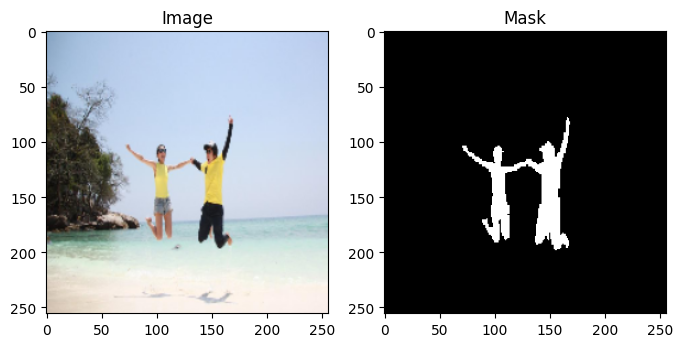

In [63]:
def visualize_sample(dataset, idx):
  image, mask = dataset[idx]
  image = image.permute(1, 2, 0)  # Reorder dimensions for plotting (C, H, W) -> (H, W, C)

  plt.figure(figsize=(8, 4))

  # Plot image
  plt.subplot(1, 2, 1)
  plt.imshow(image)
  plt.title("Image")

  # Plot mask
  plt.subplot(1, 2, 2)
  plt.imshow(mask.squeeze(), cmap="gray")
  plt.title("Mask")

  plt.show()

# Visualize an example from the training dataset
visualize_sample(train_dataset, 36)

Модели из segmentation_models.pytorch

In [139]:
torch.cuda.empty_cache()
model_unet_plus_plus = smp.UnetPlusPlus(
    encoder_name = 'resnet34',
    encoder_weights = 'imagenet',
    in_channels=3,
    classes = 1
).to(device)

model_fpn = smp.FPN(
    encoder_name = 'resnet34',
    encoder_weights = 'imagenet',
    in_channels=3,
    classes = 1
).to(device)

model_deeplabv3 = smp.DeepLabV3(
    encoder_name = 'resnet34',
    encoder_weights = 'imagenet',
    in_channels=3,
    classes = 1
).to(device)

Функция обучения модели

In [206]:
def train_model(model, tload, vload, lerate):

  criterion = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=lerate)

  n_total_steps = len(tload)

  history = {
    'val_iou': [],
    'val_recall': [],
    'val_f1': []
  }

  for epoch_i in range(epoch_num):
    model.train()

    progress_bar = tqdm(tload, desc=f'Epoch {epoch_i + 1}/{epoch_num} (train)')

    for batch_i, (images, masks) in enumerate(progress_bar):
      images = images.to(device)
      masks = masks.to(device)

      outputs = model(images)
      loss = criterion(outputs, masks)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()


    model.eval()
    val_iou = 0.0
    val_recall = 0.0
    val_f1 = 0.0

    with torch.no_grad():
      for batch_i, (images, masks) in enumerate(tqdm(vload, desc=f'Epoch {epoch_i + 1}/{epoch_num} (val)')):
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        preds = (outputs > 0.5).float()

        # print('images shape', images.shape)
        # print('outputs shape', outputs.shape)

        val_iou += calculate_iou(preds.bool(), masks.bool())
        val_recall += calculate_recall(preds.bool(), masks.bool())
        val_f1 += calculate_f1(preds.bool(), masks.bool())

    val_iou /= len(vload)
    val_recall /= len(vload)
    val_f1 /= len(vload)

    history['val_iou'].append(val_iou)
    history['val_recall'].append(val_recall)
    history['val_f1'].append(val_f1)

  return history

Обучение моделей

In [142]:
torch.cuda.empty_cache()
unetpp_history = train_model(model_unet_plus_plus)

Epoch 10/10 (val): 100%|█████████████████████████████████████████████████████████████| 142/142 [00:11<00:00, 12.32it/s]


In [143]:
torch.cuda.empty_cache()
fpn_history = train_model(model_fpn)

Epoch 10/10 (val): 100%|█████████████████████████████████████████████████████████████| 142/142 [00:10<00:00, 13.58it/s]


In [144]:
torch.cuda.empty_cache()
deeplabv3_history = train_model(model_deeplabv3)

Epoch 10/10 (val): 100%|█████████████████████████████████████████████████████████████| 142/142 [00:11<00:00, 11.88it/s]


Предикт против ground truth

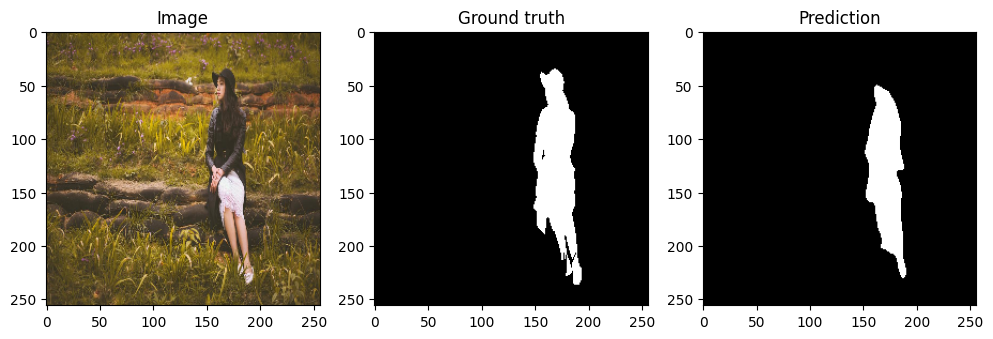

In [165]:
test_index = 8

model_unet_plus_plus.eval()

image, mask = val_dataset[test_index]
image_plt = image.permute(1, 2, 0)

plt.figure(figsize=(12, 8))

# Plot image
plt.subplot(1, 3, 1)
plt.imshow(image_plt)
plt.title("Image")

# Plot ground truth
plt.subplot(1, 3, 2)
plt.imshow(mask.squeeze(), cmap="gray")
plt.title("Ground truth")

# Plot predict
with torch.no_grad():
  image_tensor = image.unsqueeze(0).to(device)
  output = model_unet_plus_plus(image_tensor)
  pred = (output > 0.5).float().cpu().squeeze().numpy()

plt.subplot(1, 3, 3)
plt.imshow(pred, cmap='gray')
plt.title('Prediction')

plt.show()

Метрики

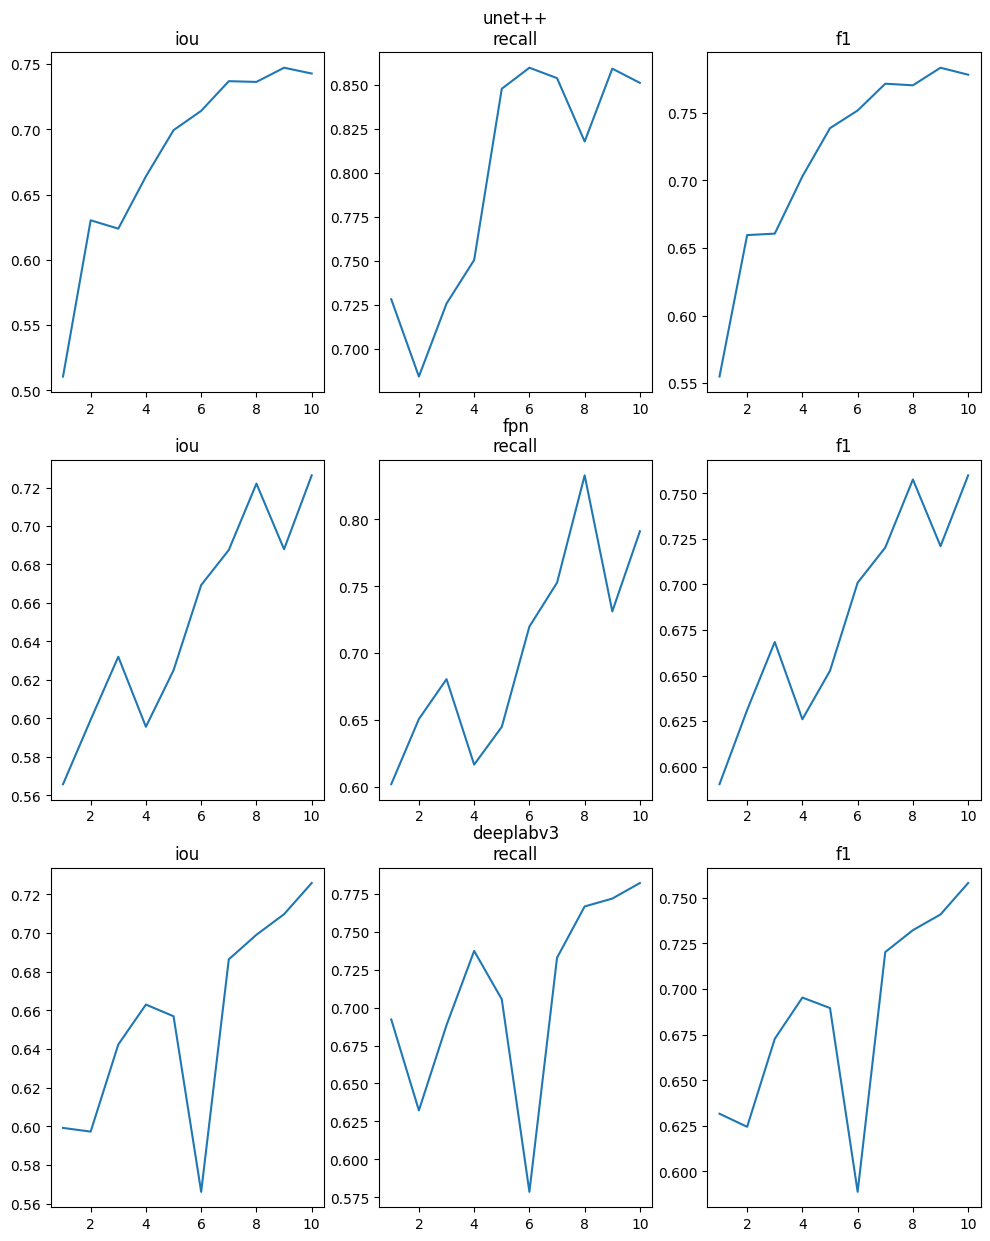

In [173]:
def to_np(arr):
  r = []
  for i in range(len(arr)):
    r.append(0)
    r[i] = arr[i].item()
  return r

plt.figure(figsize=(12, 15))


plt.subplot(3, 3, 1)
plt.plot(range(1, epoch_num + 1), to_np(unetpp_history['val_iou']))
plt.title('iou')

plt.subplot(3, 3, 2)
plt.plot(range(1, epoch_num + 1), to_np(unetpp_history['val_recall']))
plt.title('unet++\nrecall')

plt.subplot(3, 3, 3)
plt.plot(range(1, epoch_num + 1), to_np(unetpp_history['val_f1']))
plt.title('f1')


plt.subplot(3, 3, 4)
plt.plot(range(1, epoch_num + 1), to_np(fpn_history['val_iou']))
plt.title('iou')

plt.subplot(3, 3, 5)
plt.plot(range(1, epoch_num + 1), to_np(fpn_history['val_recall']))
plt.title('fpn\nrecall')

plt.subplot(3, 3, 6)
plt.plot(range(1, epoch_num + 1), to_np(fpn_history['val_f1']))
plt.title('f1')


plt.subplot(3, 3, 7)
plt.plot(range(1, epoch_num + 1), to_np(deeplabv3_history['val_iou']))
plt.title('iou')

plt.subplot(3, 3, 8)
plt.plot(range(1, epoch_num + 1), to_np(deeplabv3_history['val_recall']))
plt.title('deeplabv3\nrecall')

plt.subplot(3, 3, 9)
plt.plot(range(1, epoch_num + 1), to_np(deeplabv3_history['val_f1']))
plt.title('f1')


plt.show()

In [150]:
torch.save(model_unet_plus_plus, 'upp.pth')
torch.save(model_fpn, 'fpn.pth')
torch.save(model_deeplabv3, 'dlv3.pth')

In [ ]:
!dir

Гипотезы:
* Уменьшить LR
* Добавить повороты изображений

Новые модели:

In [186]:
torch.cuda.empty_cache()
better_upp = smp.UnetPlusPlus(
    encoder_name = 'resnet34',
    encoder_weights = 'imagenet',
    in_channels=3,
    classes = 1
).to(device)

better_fpn = smp.FPN(
    encoder_name = 'resnet34',
    encoder_weights = 'imagenet',
    in_channels=3,
    classes = 1
).to(device)

better_dlv3 = smp.DeepLabV3(
    encoder_name = 'resnet34',
    encoder_weights = 'imagenet',
    in_channels=3,
    classes = 1
).to(device)

Обучение

In [194]:
torch.cuda.empty_cache()
better_upp_history = train_model(better_upp, better_train_loader, better_valid_loader)

Epoch 10/10 (val): 100%|█████████████████████████████████████████████████████████████| 142/142 [00:10<00:00, 13.16it/s]


In [195]:
torch.cuda.empty_cache()
better_fpn_history = train_model(better_fpn, better_train_loader, better_valid_loader)

Epoch 10/10 (val): 100%|█████████████████████████████████████████████████████████████| 142/142 [00:09<00:00, 14.98it/s]


In [196]:
torch.cuda.empty_cache()
better_dlv3_history = train_model(better_dlv3, better_train_loader, better_valid_loader)

Epoch 10/10 (val): 100%|█████████████████████████████████████████████████████████████| 142/142 [00:14<00:00, 10.00it/s]


In [197]:
torch.save(better_upp, 'bupp.pth')
torch.save(better_fpn, 'bfpn.pth')
torch.save(better_dlv3, 'bdlv3.pth')

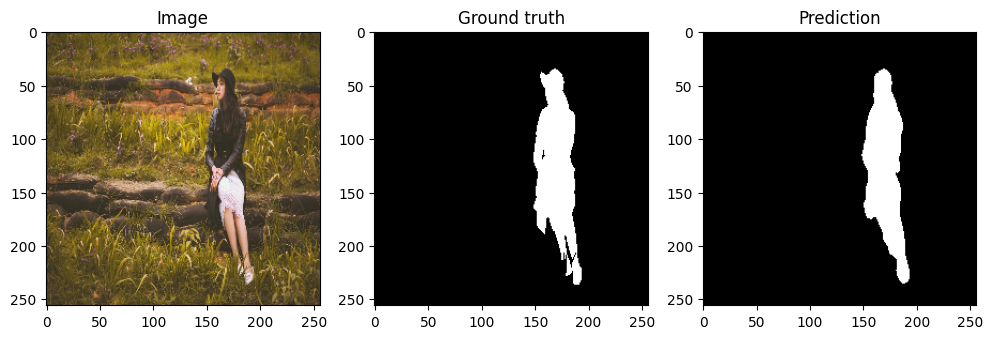

In [198]:
test_index = 8

better_upp.eval()

image, mask = better_val_dataset[test_index]
image_plt = image.permute(1, 2, 0)

plt.figure(figsize=(12, 8))

# Plot image
plt.subplot(1, 3, 1)
plt.imshow(image_plt)
plt.title("Image")

# Plot ground truth
plt.subplot(1, 3, 2)
plt.imshow(mask.squeeze(), cmap="gray")
plt.title("Ground truth")

# Plot predict
with torch.no_grad():
  image_tensor = image.unsqueeze(0).to(device)
  output = better_upp(image_tensor)
  pred = (output > 0.5).float().cpu().squeeze().numpy()

plt.subplot(1, 3, 3)
plt.imshow(pred, cmap='gray')
plt.title('Prediction')

plt.show()

Метрики улучшенного бейзлайна

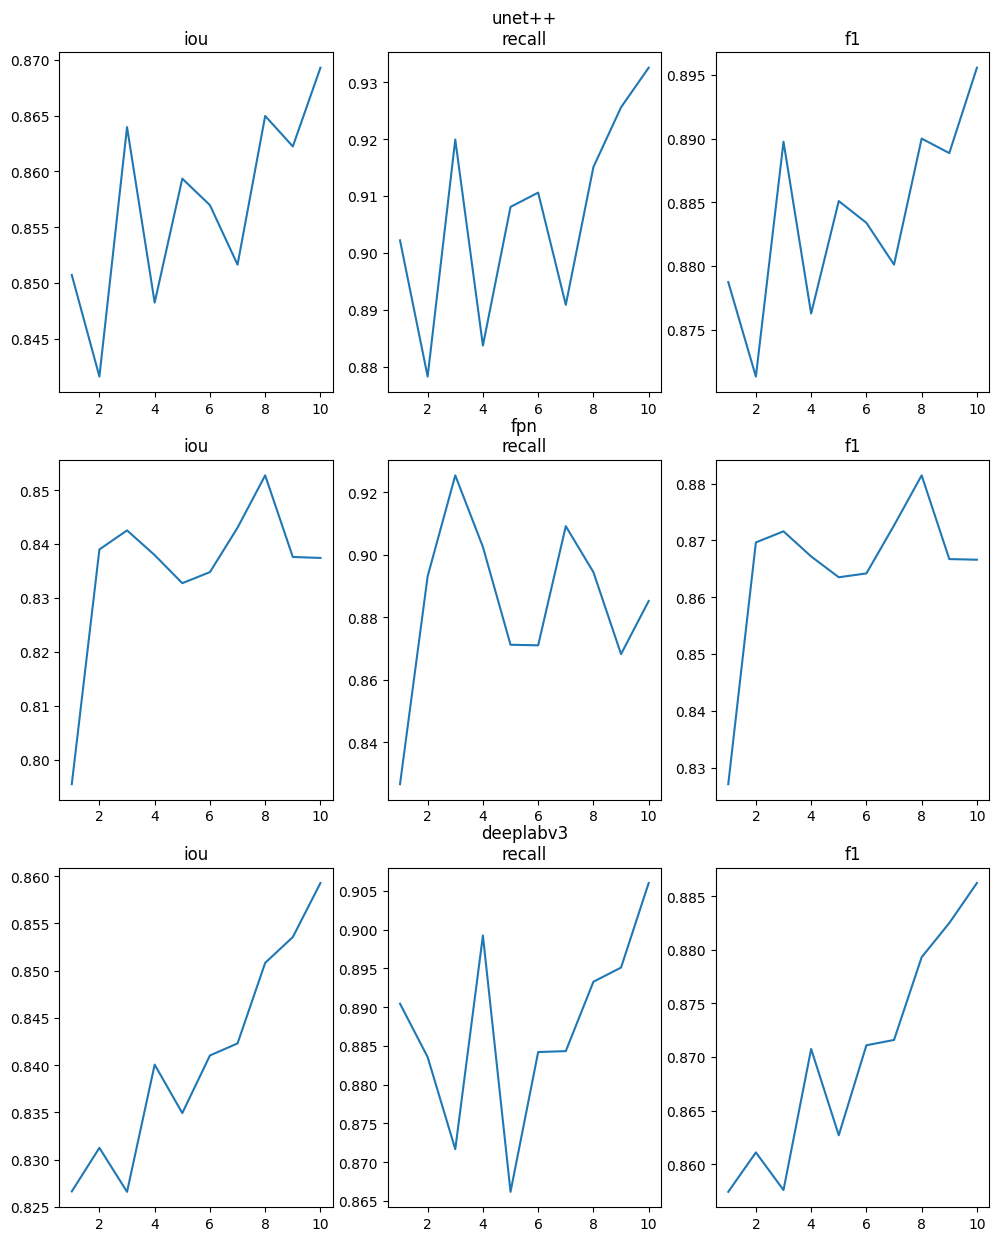

In [199]:
plt.figure(figsize=(12, 15))


plt.subplot(3, 3, 1)
plt.plot(range(1, epoch_num + 1), to_np(better_upp_history['val_iou']))
plt.title('iou')

plt.subplot(3, 3, 2)
plt.plot(range(1, epoch_num + 1), to_np(better_upp_history['val_recall']))
plt.title('unet++\nrecall')

plt.subplot(3, 3, 3)
plt.plot(range(1, epoch_num + 1), to_np(better_upp_history['val_f1']))
plt.title('f1')


plt.subplot(3, 3, 4)
plt.plot(range(1, epoch_num + 1), to_np(better_fpn_history['val_iou']))
plt.title('iou')

plt.subplot(3, 3, 5)
plt.plot(range(1, epoch_num + 1), to_np(better_fpn_history['val_recall']))
plt.title('fpn\nrecall')

plt.subplot(3, 3, 6)
plt.plot(range(1, epoch_num + 1), to_np(better_fpn_history['val_f1']))
plt.title('f1')


plt.subplot(3, 3, 7)
plt.plot(range(1, epoch_num + 1), to_np(better_dlv3_history['val_iou']))
plt.title('iou')

plt.subplot(3, 3, 8)
plt.plot(range(1, epoch_num + 1), to_np(better_dlv3_history['val_recall']))
plt.title('deeplabv3\nrecall')

plt.subplot(3, 3, 9)
plt.plot(range(1, epoch_num + 1), to_np(better_dlv3_history['val_f1']))
plt.title('f1')


plt.show()

Как видим метрики улучшились и видно как предикт стал более точным на визуализации

Кастомная модель

In [202]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class CustomUnet(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(CustomUnet, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [208]:
custom_model = CustomUnet().to(device)
better_custom_model = CustomUnet().to(device)

In [209]:
chistory = train_model(custom_model, train_loader, valid_loader, 0.01)

Epoch 10/10 (val): 100%|█████████████████████████████████████████████████████████████| 142/142 [00:15<00:00,  9.10it/s]


In [210]:
bchistory = train_model(better_custom_model, better_train_loader, better_valid_loader, 0.0001)

Epoch 10/10 (val): 100%|█████████████████████████████████████████████████████████████| 142/142 [00:12<00:00, 11.21it/s]


In [211]:
torch.save(custom_model, 'customseg.pth')
torch.save(better_custom_model, 'bettercustomseg.pth')

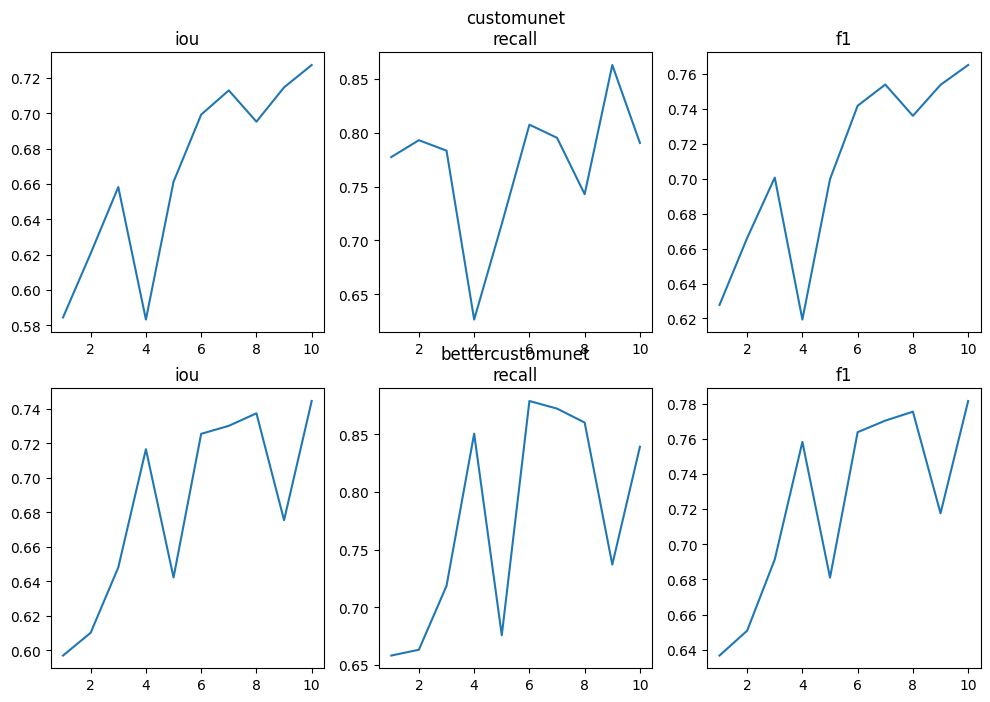

In [213]:
plt.figure(figsize=(12, 8))


plt.subplot(2, 3, 1)
plt.plot(range(1, epoch_num + 1), to_np(chistory['val_iou']))
plt.title('iou')

plt.subplot(2, 3, 2)
plt.plot(range(1, epoch_num + 1), to_np(chistory['val_recall']))
plt.title('customunet\nrecall')

plt.subplot(2, 3, 3)
plt.plot(range(1, epoch_num + 1), to_np(chistory['val_f1']))
plt.title('f1')


plt.subplot(2, 3, 4)
plt.plot(range(1, epoch_num + 1), to_np(bchistory['val_iou']))
plt.title('iou')

plt.subplot(2, 3, 5)
plt.plot(range(1, epoch_num + 1), to_np(bchistory['val_recall']))
plt.title('bettercustomunet\nrecall')

plt.subplot(2, 3, 6)
plt.plot(range(1, epoch_num + 1), to_np(bchistory['val_f1']))
plt.title('f1')


plt.show()

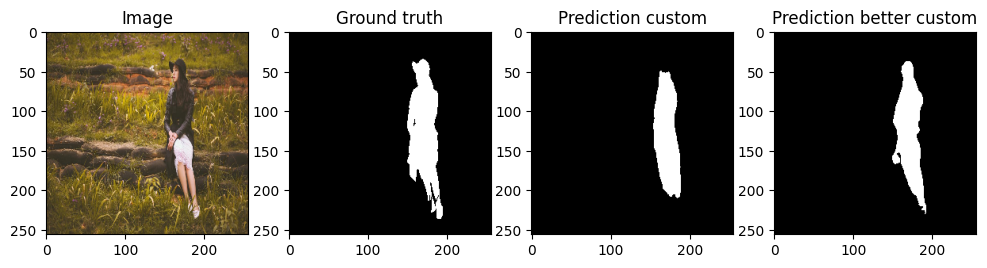

In [214]:
test_index = 8

custom_model.eval()
better_custom_model.eval()

image, mask = better_val_dataset[test_index]
image_plt = image.permute(1, 2, 0)

plt.figure(figsize=(12, 8))

# Plot image
plt.subplot(1, 4, 1)
plt.imshow(image_plt)
plt.title("Image")

# Plot ground truth
plt.subplot(1, 4, 2)
plt.imshow(mask.squeeze(), cmap="gray")
plt.title("Ground truth")

# Plot predict custom
with torch.no_grad():
  image_tensor = image.unsqueeze(0).to(device)
  output = custom_model(image_tensor)
  pred = (output > 0.5).float().cpu().squeeze().numpy()

plt.subplot(1, 4, 3)
plt.imshow(pred, cmap='gray')
plt.title('Prediction custom')


# Plot predict better custom
with torch.no_grad():
  image_tensor = image.unsqueeze(0).to(device)
  output = better_custom_model(image_tensor)
  pred = (output > 0.5).float().cpu().squeeze().numpy()

plt.subplot(1, 4, 4)
plt.imshow(pred, cmap='gray')
plt.title('Prediction better custom')

plt.show()

Можно сделать вывод, что предложенные улучшения заметно повышаеют качество как кастомной модели, так и предобученной. Очевидно, предобученные модели сильнее кастомной модели. Для более детального сравнения и оценки можно было бы увеличить число эпох.